# Best Subset Feature Selection using Multi-Layer Perceptron

## Contents

- Multi-Layer Perceptron fitting with Pima Indians Diabetes data
     - Data overview
     - Data preprocessing
     - MLP fitting
     - MLP evaluation
- Best Subset Feature Selection
     - Function implementation
     - Example

In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from itertools import combinations

import pandas as pd

import numpy as np

import time

## Dataset
### Pima Indians Diabetes dataset
768 Observations of people classified as either having the onset of diabetes within 5 years (1) or not (0), given various medical attributes (binary classification with all numeric features).

 [More info](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names)

[Download CSV](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv)

In [2]:
# reading and cleaning data
df = pd.read_csv('pima-indians-diabetes.data', sep=',', header=None)

# columns are currently named by numbers 0:8, with 8 containing the class of the observation.
# Renaming to easier identify columns.

# feature names created from column descriptions
features = [
    'pregnant_cnt',
    'glucose',
    'blood_pressure',
    'triceps_skinfold',
    'insulin',
    'bmi',
    'diabetes_pedigree',
    'age'
]

for i in range(8):
    df = df.rename(columns = {i : features[i]})

df = df.rename(columns = {8 : 'label'})
df.head()

,pregnant_cnt,glucose,blood_pressure,triceps_skinfold,insulin,bmi,diabetes_pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<AxesSubplot:>

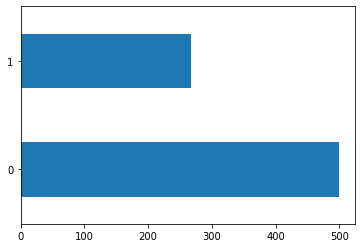

In [3]:
# displaying data
df['label'].value_counts().plot(kind='barh')

In [4]:
# creating train and test splits for X (feature values) and y (labels)
X = df.drop(['label'], axis=1)
y = df['label']

# creating training and testing data splits, setting the split at 30% test and 70% train.
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y, random_state = 0)

# Standardizing data (mapping to CHECK) to allow for faster convergence.
sc = preprocessing.StandardScaler()
# fit StandardScaler only on training data, as to not bias the data with information outside of training scope
sc.fit(X_train)

# using fit StandardScalar to standardize feature data (every feature is numerical).
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

[scikit-learn multi-layer perceptron classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
### Fitting and predicting using multi-layer perceptron
**Params:**
- *hidden_layer_sizes*: the size of each hidden layer
- *activation*: specifying activation function for hidden layers {identity, logistic, tanh, relu}
- *solver*: specifying solver for weight optimization {lbfgs, sgd, adam}
- *alpha*: L2 penalty parameter, specifies value to shrink certain nodes to help prevent overfitting
- *max_iter*: how many iterations we allow the model to attempt to converge
- *random_state*: setting random state for repeatability

In [5]:
# initializing parameters for easier understanding
hidden_layer_sizes = (100,100,100)
activation = 'relu'
solver = 'adam'
alpha = 0.0001
n_iter = 500
random_state = 0

# creating and fitting multi-layer perceptron
mlp = MLPClassifier(
    hidden_layer_sizes = hidden_layer_sizes,
    activation = activation,
    solver = solver,
    alpha = alpha,
    max_iter=n_iter,
    random_state=random_state
)
mlp.fit(X_train_scaled, y_train)

# using fitted multi-layer perceptron to predict on test data
y_pred = mlp.predict(X_test_scaled)

Accuracy: 0.7403
10-fold CV Score: 0.7018
Precision: 0.6438
Recall: 0.5802


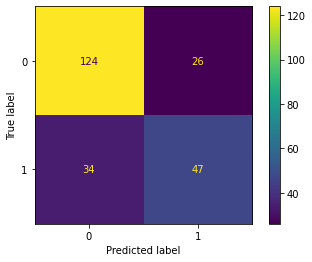

In [6]:
# creating confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=mlp.classes_)

# outputting accuracy score
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')

# 10-fold cross-validation
print(f'10-fold CV Score: {cross_val_score(mlp, X, y, cv=10).mean():.4f}')

# getting precision and recall
tp = cm[1][1]
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]

print(f'Precision: {tp/(tp+fp):.4f}\nRecall: {tp/(tp+fn):.4f}')

# plotting confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
cm_display.plot()

## Best feature subset
There is currently no functionality built into sklearn to identify best feature subsets. Therefore, our own function must be written to accomplish this. The functions defined below select the best subset of features for a given subset length using its cross validation score.

In [7]:
# finding best feature subset

# params
# X: feature values
# y: labels
# model: fitted classifier object
# subset_len: how many features the desired feature subset will have
# cv: number of folds for cross validation scoring
def best_subset(X, y, model, subset_len, cv=3, verbose=False):
    
    # for elapsed time
    start = time.time()
    
    # getting number of features
    l = X.shape[1]
    
    # getting all the different possible combinations of features for the given
    # subset length
    subsets = list(combinations(range(l), subset_len))
    print(f'{len(subsets)} total combinations for subset length {subset_len}.')
    
    # setting baseline values for best score and subset to update later
    best_score = -np.inf
    best_subset = None
    
    # iterating through possible combinations
    for subset in subsets:
        
        # subset is currently an index, need to get feature names to select df
        subset_nm = [X.columns[i] for i in subset]
        
        # getting CV score from model with subsetted features
        score = cross_val_score(model, X[subset_nm], y, cv=cv).mean()
        
        if verbose:
            print(f'Current subset: {subset_nm}\nScore: {score}')
        
        # updating best score and best subset if a new best score happens
        if score > best_score:
            best_score, best_subset = score, subset
            
    # for elapsed time
    end = time.time()
    
    # printing and returning metrics
    print(f'Elapsed time: {int((end - start)/60)} min. and {(end - start)%60} sec.\n')
    return [[X.columns[i] for i in best_subset], best_score]

# Function to iterate through multiple subset lengths and return a df of
# associated features and CV scores
#
# params
# X: feature values
# y: labels
# model: fitted classifier object
# min_subset_len: lowest number of features for a subset
# max_subset_len: greatest number of features for a subset
# cv: number of folds for cross validation scoring
# verbose: prints each combination
def best_subsets(X, y, model, min_subset_len, max_subset_len, cv=3, verbose=False):
    
    # lists to later create df with
    subset_length = list()
    subset_features = list()
    subset_cv_score = list()
    
    # iterating through desired subset lengths
    for i in range(min_subset_len, max_subset_len+1):
        best = best_subset(X, y, mlp, i, cv=cv, verbose=verbose)
        
        # adding to lists to create df with later
        subset_length.append(i)
        subset_features.append(best[0])
        subset_cv_score.append(best[1])
        
    # creating and returning dataframe with length, feature list, and score for
    # each desired subset length
    df = pd.DataFrame(data={'length': subset_length, 'features': subset_features, 'cv_score': subset_cv_score})
    return df

## example runs for best feature subset

In [10]:
# first, we will find the best subset for 6 features with verbose=True to show
# process of scoring all subsets
best_subset(X, y, mlp, 6, verbose=True)

28 total combinations for subset length 6.
Current subset: ['pregnant_cnt', 'glucose', 'blood_pressure', 'triceps_skinfold', 'insulin', 'bmi']
Score: 0.6419270833333334
Current subset: ['pregnant_cnt', 'glucose', 'blood_pressure', 'triceps_skinfold', 'insulin', 'diabetes_pedigree']
Score: 0.6549479166666666
Current subset: ['pregnant_cnt', 'glucose', 'blood_pressure', 'triceps_skinfold', 'insulin', 'age']
Score: 0.6822916666666666
Current subset: ['pregnant_cnt', 'glucose', 'blood_pressure', 'triceps_skinfold', 'bmi', 'diabetes_pedigree']
Score: 0.6901041666666666
Current subset: ['pregnant_cnt', 'glucose', 'blood_pressure', 'triceps_skinfold', 'bmi', 'age']
Score: 0.6966145833333334
Current subset: ['pregnant_cnt', 'glucose', 'blood_pressure', 'triceps_skinfold', 'diabetes_pedigree', 'age']
Score: 0.6927083333333334
Current subset: ['pregnant_cnt', 'glucose', 'blood_pressure', 'insulin', 'bmi', 'diabetes_pedigree']
Score: 0.6692708333333334
Current subset: ['pregnant_cnt', 'glucose', 

[['pregnant_cnt',
  'glucose',
  'blood_pressure',
  'bmi',
  'diabetes_pedigree',
  'age'],
 0.7044270833333334]

In [11]:
# next, we will search for the best subset between 1 feature and 8 features.

subsets_df = best_subsets(X, y, mlp, min_subset_len=1, max_subset_len=8, cv=3)
print('Top three feature subsets:')
print(subsets_df.sort_values(by='cv_score', ascending=False).head(3))
best_subset_ftrs = subsets_df[subsets_df.cv_score == max(subsets_df.cv_score)]
print('Best feature subset:')
for f in best_subset_ftrs.features:
    print(f)

8 total combinations for subset length 1.
Elapsed time: 0 min. and 5.989090442657471 sec.

28 total combinations for subset length 2.
Elapsed time: 0 min. and 25.381166458129883 sec.

56 total combinations for subset length 3.
Elapsed time: 1 min. and 13.22566270828247 sec.

70 total combinations for subset length 4.
Elapsed time: 1 min. and 22.834959506988525 sec.

56 total combinations for subset length 5.
Elapsed time: 0 min. and 56.1278018951416 sec.

28 total combinations for subset length 6.
Elapsed time: 0 min. and 38.1639358997345 sec.

8 total combinations for subset length 7.
Elapsed time: 0 min. and 8.613581895828247 sec.

1 total combinations for subset length 8.
Elapsed time: 0 min. and 1.9814140796661377 sec.

Top three feature subsets:
   length                                           features  cv_score
4       5  [glucose, blood_pressure, bmi, diabetes_pedigr...  0.726562
2       3                     [glucose, blood_pressure, age]  0.713542
3       4  [glucose, blood